In [1]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from pyomo.environ import *
import time
import random
from geneticalgorithm import geneticalgorithm as ga


## MINLP Solver

In [46]:
### Simple linear programming sample
# Create the model
model = LpProblem(name="small-problem", sense=LpMaximize)

# Initialize the decision variables
x = LpVariable(name="x", lowBound=0)
y = LpVariable(name="y", lowBound=0)

# Add the constraints to the model
model += (2 * x + y <= 20, "red_constraint")
model += (4 * x - 5 * y >= -10, "blue_constraint")
model += (-x + 2 * y >= -2, "yellow_constraint")
model += (-x + 5 * y == 15, "green_constraint")

# Add the objective function to the model
obj_func = x + 2 * y
model += obj_func

# Solve the problem
LpSolverDefault.msg = 1
status = model.solve()

print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

for var in model.variables():
    print(f"{var.name}: {var.value()}")

for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/d2d768c9419c4e6bb784fd9608ba3848-pulp.mps max branch printingOptions all solution /var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/d2d768c9419c4e6bb784fd9608ba3848-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 20 RHS
At line 25 BOUNDS
At line 26 ENDATA
Problem MODEL has 4 rows, 2 columns and 8 elements
Coin0008I MODEL read with 0 errors
Presolve 0 (-4) rows, 0 (-2) columns and 0 (-8) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 16.818182
After Postsolve, objective 16.818182, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 16.81818182 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total tim

In [2]:
def toy_model(t, y, ydot, params):
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    T = 1; E = 2; X = 2
    A, W = params
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    for e in range(E):
        ydot[e+X] = -lam*y[e+X] + np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]]))
    ydot[E+X] = (Vin - y[X+1]*nonlinearity(y[X-1], kc, km))**2 #J1
    ydot[E+X+1] = np.sum([np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]])) for e in range(E)]) #J2

def arch_converter(A):
    if A == 1:
        return ((0, 1, 0), (1, 0, 0))

    elif A == 2:
        return ((0, 0, 1), (0, 0, 1))

    elif A == 3:
        return ((0, 0, 1), (1, 0, 0))

    elif A == 4:
        return ((0, 1, 0), (0, 0, 1))
    else: return 'Invalid Circuit'

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'No Control'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)
    
def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

In [10]:
### Toy model sample
# Create the model
model = pl.LpProblem(name="toy-ode", sense=pl.LpMinimize)

# Initialize the decision variables
A = pl.LpVariable("A", lowBound=0, upBound=4, cat="Integer")
k1 = pl.LpVariable("k1", lowBound=1E-7, upBound=1E-3, cat="Continuous")
k2 = pl.LpVariable("k2", lowBound=1E-7, upBound=1E-3, cat="Continuous")
theta1 = pl.LpVariable("theta1", lowBound=0.001, upBound=10, cat="Continuous")
theta2 = pl.LpVariable("theta2", lowBound=0.001, upBound=10, cat="Continuous")
A.setInitialValue(1)
k1.setInitialValue(1.E-5)
k2.setInitialValue(1.E-5)
theta1.setInitialValue(1.)
theta2.setInitialValue(1.)

model.addVariable(k1)
model.addVariable(k2)
model.addVariable(theta1)
model.addVariable(theta2)
model.addVariable(A)

# Add the constraints to the model
def ode_fun(A, k1, k2, theta1, theta2):
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = arch_converter(A.value())
    param_values = [[2., k1.value(), theta1.value()], [2., k2.value(), theta2.value()]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    if solution.flag != 'StatusEnum.TOO_MUCH_WORK':
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
        return loss
    return 1.E7

# Add the objective function to the model
model += ode_fun(A, k1, k2, theta1, theta2)

# Solve the problem
solver = pl.PULP_CBC_CMD(msg=True, warmStart=True)
status = model.solve(solver)

print(f"status: {model.status}, {pl.LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

for var in model.variables():
    print(f"{var.name}: {var.value()}")

model

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/7e0b90fdc91e48c8a121b63d0ec38b37-pulp.mps mips /var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/7e0b90fdc91e48c8a121b63d0ec38b37-pulp.mst timeMode elapsed branch printingOptions all solution /var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/7e0b90fdc91e48c8a121b63d0ec38b37-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 9 RHS
At line 10 BOUNDS
No match for column X0000000 at line 11 <  UP BND       X0000000   4.000000000000e+00 >
No match for column X0000002 at line 13 <  LO BND       X0000002   1.000000000000e-07 >
No match for column X0000002 at line 14 <  UP BND       X0000002   1.000000000000e-03 >
No match for column X0000003 at line 15 <  LO BND       X0000003   1.000000000000e-07 >


PulpSolverError: Pulp: Error while executing /Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc

In [22]:
from scipy.optimize import Bounds, minimize

bounds = Bounds([1, 1E-7, 1E-7, 0.001, 0.001], [4, 0.001, 0.001, 10., 10.])

def arch_converter(A):
    if A < 1:
        return ((0, 1, 0), (1, 0, 0))

    elif A < 2:
        return ((0, 0, 1), (0, 0, 1))

    elif A < 3:
        return ((0, 0, 1), (1, 0, 0))

    elif A <= 4:
        return ((0, 1, 0), (0, 0, 1))
    else: return 'Invalid Circuit'

def ode_fun(x):
    A, k1, k2, theta1, theta2 = x
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = arch_converter(A)
    param_values = [[2., k1, theta1], [2., k2, theta2]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    if solution.flag != 'StatusEnum.TOO_MUCH_WORK':
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
        return loss
    return 1.E7

init_values = [random.randint(1, 4), np.random.uniform(1E-7, 1E-3), np.random.uniform(1E-7, 1E-3), np.random.uniform(0.001, 10.), np.random.uniform(0.001, 10.)]
sol = minimize(ode_fun, init_values, bounds=bounds)
sol

AttributeError: 'numpy.float64' object has no attribute 'value'

In [32]:
from scipy.optimize import milp, LinearConstraint

c = np.array([0., 0., 0., 0., 0., ode(fun())])
A = np.identity(6)
constraints =  LinearConstraint(A, [1, 1E-7, 1E-7, 0.001, 0.001, -np.inf()], [4, 0.001, 0.001, 10., 10., np.inf()])
integrality = np.array([1, 0, 0, 0, 0])

res = milp(c=c, constraints=constraints, integrality=integrality)
res

            fun: 1.0002
        message: 'Optimization terminated successfully. (HiGHS Status 7: Optimal)'
 mip_dual_bound: 1.0002
        mip_gap: 0.0
 mip_node_count: 0
         status: 0
        success: True
              x: array([1.   , 0.   , 0.   , 0.001, 0.001])

In [20]:
model = ConcreteModel()
model.x = Var(bounds=(1.0,10.0),initialize=5.0)
model.y = Var(within=Binary)
model.c1 = Constraint(expr=(model.x-4.0)**2 - model.x <= 50.0*(1-model.y))
model.c2 = Constraint(expr=model.x*log(model.x)+5.0 <= 50.0*(model.y))
model.objective = Objective(expr=model.x, sense=minimize)
SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt') 

# model.objective.display()
# model.display()
# model.pprint()

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 2 constraints (2 nonlinear) and 0 disjunctions, with 2 variables, of which 1 are binary, 0 are integer, and 1 are continuous.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP                 1            inf              1      nan%      0.31
         1              MILP                 1            inf              1      nan%      0.34
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP                 1            inf   

{'Problem': [{'Name': 'unknown', 'Lower bound': 2.43844718719117, 'Upper bound': 2.4384471872707754, 'Number of objectives': 1, 'Number of constraints': 2, 'Number of variables': 2, 'Number of binary variables': 1, 'Number of integer variables': 0, 'Number of continuous variables': 1, 'Number of nonzeros': None, 'Sense': 'minimize', 'Number of disjunctions': 0}], 'Solver': [{'Name': 'MindtPyOA', 'Status': 'ok', 'Message': None, 'User time': None, 'System time': None, 'Wallclock time': None, 'Termination condition': 'optimal', 'Termination message': None, 'Timing': Bunch(Call after main solve = 3.224999989015487e-05, Call after subproblem solve = 1.2374999869280146e-05, OA cut generation = 0.001118582999993123, feasibility subproblem = 0.2528556249999383, fixed subproblem = 0.5235396670000227, initialization = 0.31147999999996046, main = 0.07131970899990847, main loop = 0.8621800829999984, main_timer_start_time = 963.072631292, total = 1.1775374160000638), 'Iterations': 3, 'Num infeasib

In [38]:
model = ConcreteModel()
model.k1 = Var(bounds=(1E-7,0.001),initialize=np.random.uniform(1E-7, 1E-3))
model.k2 = Var(bounds=(1E-7,0.001),initialize=np.random.uniform(1E-7, 1E-3))
model.theta1 = Var(bounds=(1E-3,10.),initialize=np.random.uniform(0.001, 10.))
model.theta2 = Var(bounds=(1E-3,10.),initialize=np.random.uniform(0.001, 10.))
model.A = Var(bounds=(1,4),domain=PositiveIntegers, initialize=random.randint(1, 4))

def ode_fun(A, k1, k2, theta1, theta2):
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = arch_converter(A.value)
    param_values = [[2., k1.value, theta1.value], [2., k2.value, theta2.value]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-4}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    if solution.flag != 'StatusEnum.TOO_MUCH_WORK':
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
        return loss
    return 1.E7

model.c1 = Constraint(expr=model.k1 <= model.k1)
model.c2 = Constraint(expr=model.k2 <= model.k2)
model.c3 = Constraint(expr=model.theta1 <= model.theta1)
model.c4 = Constraint(expr=model.theta2 <= model.theta2)
model.c5 = Constraint(expr=model.A == model.A)

model.objective = Objective(rule=ode_fun(model.A, model.k1, model.k2, model.theta1, model.theta2), sense=minimize)
SolverFactory('mindtpy').solve(model, strategy='GOA', mip_solver='glpk', nlp_solver='ipopt') 

model.objective.display()
# model.display()
# model.k1.pprint()

ERROR: Rule failed when generating expression for Objective objective with
    index None: TypeError: 'ConcreteModel' object is not callable
ERROR: Constructing component 'objective' from data=None failed: TypeError:
    'ConcreteModel' object is not callable


TypeError: 'ConcreteModel' object is not callable

## Genetic Algorithm

 The best solution found:                                                                           
 [0.50218658 1.         0.        ]

 Objective function:
 1.5021865778480261


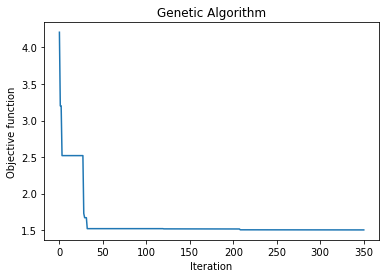

In [33]:
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    return np.sum(X)
    
varbound=np.array([[0.5,1.5],[1,100],[0,1]])
vartype=np.array([['real'],['int'],['int']])
model=ga(function=f,dimension=3,variable_type_mixed=vartype,variable_boundaries=varbound)

model.run()

|||||||||||||||||_________________________________ 33.3% GA is running...


[CVODE ERROR]  CVode
  At t = 410.899, mxstep steps taken before reaching tout.



|||||||||||||||||||||||||||||||||||||||||||||||||| 100.0% GA is running...


[CVODE ERROR]  CVode
  At t = 169.82, mxstep steps taken before reaching tout.


[CVODE ERROR]  CVode
  At t = 332.379, mxstep steps taken before reaching tout.



 The best solution found:                                                                           
 [2.00000000e+00 7.88726164e-04 9.62460508e-04 4.49906622e+00
 1.98400034e+00]

 Objective function:
 -13666922693.613224


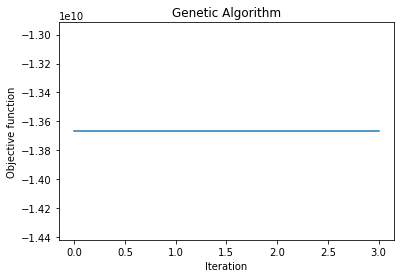

In [28]:
def f(X):
    A, k1, k2, theta1, theta2 = X
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = arch_converter(A)
    param_values = [[2., k1, theta1], [2., k2, theta2]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-3}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    if (str(solution.flag) == 'StatusEnum.SUCCESS'): return loss
    else: return 1.E7
    
varbound=np.array([[1,4],[1E-7,1E-3],[1E-7,1E-3], [1E-3, 10], [1E-3, 10]])
vartype=np.array([['int'], ['real'],['real'],['real'],['real']])


algorithm_param = {'max_num_iteration': 3,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=f,dimension=5,variable_type_mixed=vartype,variable_boundaries=varbound, algorithm_parameters=algorithm_param)

model.run()

results = model.output_dict


array([2.00000000e+00, 7.88726164e-04, 9.62460508e-04, 4.49906622e+00,
       1.98400034e+00])

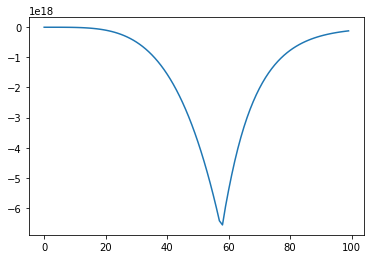

In [47]:
def f(X):
    A, k1, k2, theta1, theta2 = X
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = arch_converter(A)
    param_values = [[2., k1, theta1], [2., k2, theta2]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-3}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    return solution

sol = f(results['variable'])
plt.plot(sol.values.y[:, 0])
results['variable']

## Random Sampling and Grid Search

In [52]:
### Random sampling experiments
def solve_point(architecture, param_values):
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    return loss

def gen_ics(N):
    #Set random seed
    np.random.seed(2022)
    ics = []
    for i in range(N):
        k1 = random.uniform(1E-7,1E-3)
        k2 = random.uniform(1E-7,1E-3)
        theta1 = random.uniform(0.001,10)
        theta2 = random.uniform(0.001,10)

        init_conds = [[2.,theta1, k1], [2., theta2, k2]]
        ics.append(init_conds)
    return ics


for num_samples in [100, 1000, 10000]:
    overall_start_time = time.time()
    ics = gen_ics(num_samples)
    for A in [1, 2, 3, 4]:
        start_time = time.time()
        losses = []; k1_trace = []; k2_trace = []; n1_trace = []; n2_trace = []; theta1_trace = []; theta2_trace = []
        for j in range(len(ics)):
            init_conds = ics[j]
            [[new_n1,new_theta1, new_k1], [new_n2, new_theta2, new_k2]] = init_conds
            architecture = arch_converter(A)
            func = name_converter(architecture)
            loss = solve_point(architecture, init_conds)
            losses.append(loss)
            k1_trace.append(new_k1)
            k2_trace.append(new_k2)
            n1_trace.append(new_n1)
            n2_trace.append(new_n2)
            theta1_trace.append(new_theta1)
            theta2_trace.append(new_theta2)
        elapsed_time = time.time() - start_time
        results = pd.DataFrame({'circuit': func, 'num_samples': num_samples,'loss':losses,'k1_trace':k1_trace,'k2_trace':k2_trace,'n1_trace':n1_trace,'n2_trace':n2_trace,'theta1_trace':theta1_trace, 'theta2_trace':theta2_trace, 'time': elapsed_time})
        results.to_csv('random_sampling/'+func.lower().replace(' ', '_')+str(num_samples)+'.csv')
    overall_elapsed = time.time() - overall_start_time
    print(overall_elapsed)

16.062073707580566
159.23950099945068
1682.9257419109344


## Dataframe construction

In [65]:
#Read in random sampling results
da100 = pd.read_csv('random_sampling/downstream_activation100.csv')
da1k = pd.read_csv('random_sampling/downstream_activation1000.csv')
da10k = pd.read_csv('random_sampling/downstream_activation10000.csv')

dc100 = pd.read_csv('random_sampling/dual_control100.csv')
dc1k = pd.read_csv('random_sampling/dual_control1000.csv')
dc10k = pd.read_csv('random_sampling/dual_control10000.csv')

nc100 = pd.read_csv('random_sampling/no_control100.csv')
nc1k = pd.read_csv('random_sampling/no_control1000.csv')
nc10k = pd.read_csv('random_sampling/no_control10000.csv')

ur100 = pd.read_csv('random_sampling/upstream_repression100.csv')
ur1k = pd.read_csv('random_sampling/upstream_repression1000.csv')
ur10k = pd.read_csv('random_sampling/upstream_repression10000.csv')

#Read in grid search results
grid_search_timings = pd.DataFrame({'circuit':['Downstream Activation', 'Dual Control','Upstream Repression', 'No Control'], 'time':[375, 381, 395, 382]})
gs_losses = pd.read_csv('grid_search/grid_search_landscape_times.csv')

#Combine all into best loss/computational time dataframe
combined = pd.DataFrame(columns=['Method', 'Circuit', 'Computational Time', 'Best Loss'])

rs_times = [16.06, 159.24, 1682.93]
#Random sampling data processing
for df in [da100, da1k, da10k, dc100, dc1k, dc10k, nc100, nc1k, nc10k, ur100, ur1k, ur10k]:
    best_loss = df.loss.min()
    time = df.time[0]
    if str(df.num_samples[0]) == '100':
        method = '100 Random'
        time = rs_times[0]
    elif str(df.num_samples[0]) == '1000':
        method = '1k Random'
        time = rs_times[1]
    if str(df.num_samples[0]) == '10000':
        method = '10k Random'
        time = rs_times[2]
    row = pd.DataFrame({'Method': [method], 'Circuit': [df.circuit[0]], 'Computational Time':[time], 'Best Loss':[best_loss]})
    combined = pd.concat([combined, row])

#Grid search data processing
for c in ['Downstream Activation', 'Dual Control','Upstream Repression', 'No Control']:
    df = gs_losses.loc[gs_losses.architecture == c]
    best_loss = df.loss.min()
    time = grid_search_timings.loc[grid_search_timings.circuit == c].reset_index(drop=True).iloc[0].time
    method = 'Grid Search'

    row = pd.DataFrame({'Method': [method], 'Circuit': [c], 'Computational Time':[time], 'Best Loss':[best_loss]})
    combined = pd.concat([combined, row])

combined

,Method,Circuit,Computational Time,Best Loss
0,100 Random,Downstream Activation,16.06,0.069727
0,1k Random,Downstream Activation,159.24,0.064796
0,10k Random,Downstream Activation,1682.93,0.062044
0,100 Random,Dual Control,16.06,0.071058
0,1k Random,Dual Control,159.24,0.064976
0,10k Random,Dual Control,1682.93,0.064236
0,100 Random,No Control,16.06,0.076973
0,1k Random,No Control,159.24,0.074628
0,10k Random,No Control,1682.93,0.063139
0,100 Random,Upstream Repression,16.06,0.121934


In [93]:
#Read and parse BO results
single_architecture = pd.read_csv('../toy_model/background.csv')
single_architecture = single_architecture.loc[single_architecture['index']== 499][['Circuit', 'best_losses', 'k1', 'k2', 'theta1', 'theta2']].reset_index(drop=True).reset_index()
multi_architecture = pd.read_csv('../toy_model/background_fourarchitectures.csv')
multi_architecture = multi_architecture.loc[multi_architecture['index']== 499][['Circuit', 'best_losses', 'k1', 'k2', 'theta1', 'theta2']].reset_index(drop=True).reset_index()

with open('bayesopt_timing_singlearch.txt') as f:
    lines = f.readlines()
total_times = []
rates = []
for l in lines:
    if l[:3] == '100':
        total_times.append(l.split('[')[1].split('<')[0])
        rates.append(l.split('[')[1].split(', ')[1].split('t')[0])
rates = [float(rates[i].split('s')[0]) for i in range(len(rates))]

total_times_s = []
for i in range(len(total_times)):
    if len(total_times[i]) <= 5:
        total_times_s.append(60*float(total_times[i].split(':')[0]) + float(total_times[i].split(':')[1]))
    else: total_times_s.append(60*60*float(total_times[i].split(':')[0]) + 60*float(total_times[i].split(':')[1]) + float(total_times[i].split(':')[2]))

single_parsed = pd.DataFrame({'Model':'Toy', 'Rates':rates, 'Computational Time': total_times_s}).reset_index()

with open('bayesopt_timing_multiarch.txt') as f:
    lines = f.readlines()
total_times = []
rates = []
for l in lines:
    if l[:3] == '100':
        total_times.append(l.split('[')[1].split('<')[0])
        rates.append(l.split('[')[1].split(', ')[1].split('t')[0])
rates = [float(rates[i].split('s')[0]) for i in range(len(rates))]

total_times_s = []
for i in range(len(total_times)):
    if len(total_times[i]) <= 5:
        total_times_s.append(60*float(total_times[i].split(':')[0]) + float(total_times[i].split(':')[1]))
    else: total_times_s.append(60*60*float(total_times[i].split(':')[0]) + 60*float(total_times[i].split(':')[1]) + float(total_times[i].split(':')[2]))

multi_parsed = pd.DataFrame({'Model':'Toy', 'Rates':rates, 'Computational Time': total_times_s}).reset_index()

bo_single = pd.merge(single_parsed, single_architecture, on='index')
bo_multi = pd.merge(multi_parsed, multi_architecture, on='index')

## Visualization

Text(0, 0.5, 'Computational Time, minutes')

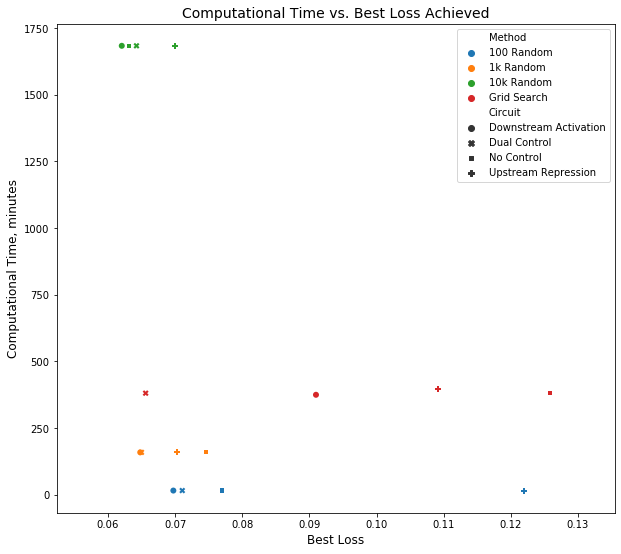

In [64]:
fig, axs = plt.subplots(1, 1, figsize=(10, 9))
endpoint = 'Computational Time vs. Best Loss Achieved'
ax = axs
plot_data = combined #.loc[combined['Method'] != 'Grid Search']
sns.scatterplot(x="Best Loss", y="Computational Time",
                hue="Method", style="Circuit",
                sizes=(1, 8), linewidth=0,
                data=plot_data, ax=ax)

ax.legend()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Best Loss', fontsize=12)
ax.set_ylabel('Computational Time, minutes', fontsize=12)

In [177]:
visualization_data = pd.DataFrame({'Method':[], 'Computational Time':[], 'Best Loss':[], 'Function Evaluations':[]})

In [178]:
### NAIVE APPROACH
#Read in random sampling results
da100 = pd.read_csv('random_sampling/downstream_activation100.csv')
da1k = pd.read_csv('random_sampling/downstream_activation1000.csv')
da10k = pd.read_csv('random_sampling/downstream_activation10000.csv')

dc100 = pd.read_csv('random_sampling/dual_control100.csv')
dc1k = pd.read_csv('random_sampling/dual_control1000.csv')
dc10k = pd.read_csv('random_sampling/dual_control10000.csv')

nc100 = pd.read_csv('random_sampling/no_control100.csv')
nc1k = pd.read_csv('random_sampling/no_control1000.csv')
nc10k = pd.read_csv('random_sampling/no_control10000.csv')

ur100 = pd.read_csv('random_sampling/upstream_repression100.csv')
ur1k = pd.read_csv('random_sampling/upstream_repression1000.csv')
ur10k = pd.read_csv('random_sampling/upstream_repression10000.csv')

#Combine all into best loss/computational time dataframe
combined = pd.DataFrame(columns=['Method', 'Circuit', 'Computational Time', 'Best Loss'])


rs_times = [16.06, 159.24, 1682.93]
#Random sampling data processing
for df in [da100, da1k, da10k, dc100, dc1k, dc10k, nc100, nc1k, nc10k, ur100, ur1k, ur10k]:
    best_loss = df.loss.min()
    time = df.time[0]
    if str(df.num_samples[0]) == '100':
        method = '100 Random'
        time = rs_times[0]
    elif str(df.num_samples[0]) == '1000':
        method = '1k Random'
        time = rs_times[1]
    if str(df.num_samples[0]) == '10000':
        method = '10k Random'
        time = rs_times[2]
    row = pd.DataFrame({'Method': [method], 'Circuit': [df.circuit[0]], 'Computational Time':[time], 'Best Loss':[best_loss]})
    combined = pd.concat([combined, row])
    
for m, num_iters in zip(['100 Random', '1k Random', '10k Random'], [100, 1000, 10000]):
    m_df = combined.loc[combined.Method == m]
    total_time = np.sum(m_df['Computational Time'])
    best_loss = m_df['Best Loss'].min()
    row = pd.DataFrame({'Method': ['Naive Approach'+' '+m], 'Computational Time': [total_time], 'Best Loss': [best_loss], 'Function Evaluations': [4*num_iters]})
    visualization_data = pd.concat([visualization_data, row])

In [179]:
###EXHAUSTIVE SEARCH
#Read in grid search results
grid_search_timings = pd.DataFrame({'circuit':['Downstream Activation', 'Dual Control','Upstream Repression', 'No Control'], 'time':[375, 381, 395, 382]})
gs_losses = pd.read_csv('grid_search/grid_search_landscape_times.csv')

#Combine all into best loss/computational time dataframe
combined = pd.DataFrame(columns=['Method', 'Circuit', 'Computational Time', 'Best Loss'])

losses = []; times = []
#Grid search data processing
for c in ['Downstream Activation', 'Dual Control','Upstream Repression', 'No Control']:
    df = gs_losses.loc[gs_losses.architecture == c]
    best_loss = df.loss.min()
    time = grid_search_timings.loc[grid_search_timings.circuit == c].reset_index(drop=True).iloc[0].time
    losses.append(best_loss)
    times.append(time)

row = pd.DataFrame({'Method': ['Exhaustive Search'], 'Computational Time': [np.sum(times)], 'Best Loss': [np.min(losses)], 'Function Evaluations': 40000})
visualization_data = pd.concat([visualization_data, row])

In [180]:
###GRADIENT-BASED METHOD
#read in GB results
gb_results = pd.read_csv('nlp_100_total.csv')
row = pd.DataFrame({'Method': ['Gradient-Based'], 'Computational Time': [np.sum(gb_results['Computational Time'])], 'Best Loss': [np.min(gb_results['Best Loss'])], 'Function Evaluations': np.sum(gb_results['Function Evaluations'])})
visualization_data = pd.concat([visualization_data, row])

In [181]:
### GLOBAL OPTIMIZATION
#Clean genetic algorithm data of runtimes etc
filenames = ['ga_samplerun.txt', 'ga_samplerun2.txt', 'ga_samplerun3.txt']
times = []
losses = []
for filename in filenames:
    with open('ga_samplerun.txt') as f:
        lines = f.readlines()

    total_time = int(lines[3].split('m')[0])*60 + int(lines[3].split(' ')[1].split('s')[0])
    times.append(total_time)

    best_loss = float(lines[-2].split(' ')[1].split(',')[0])
    losses.append(best_loss)
row = pd.DataFrame({'Method': ['Global Optimization'], 'Computational Time': [np.mean(times)], 'Best Loss': [np.mean(losses)], 'Function Evaluations': [100000]})
visualization_data = pd.concat([visualization_data, row])

In [182]:
###BAYESIAN OPTIMIZATION
#Read and parse BO results
single_architecture = pd.read_csv('../toy_model/background.csv')
single_architecture = single_architecture.loc[single_architecture['index']== 499][['Circuit', 'best_losses', 'k1', 'k2', 'theta1', 'theta2']].reset_index(drop=True).reset_index()
multi_architecture = pd.read_csv('../toy_model/background_fourarchitectures.csv')
multi_architecture = multi_architecture.loc[multi_architecture['index']== 499][['Circuit', 'best_losses', 'k1', 'k2', 'theta1', 'theta2']].reset_index(drop=True).reset_index()

with open('bayesopt_timing_singlearch.txt') as f:
    lines = f.readlines()
total_times = []
rates = []
for l in lines:
    if l[:3] == '100':
        total_times.append(l.split('[')[1].split('<')[0])
        rates.append(l.split('[')[1].split(', ')[1].split('t')[0])
rates = [float(rates[i].split('s')[0]) for i in range(len(rates))]

total_times_s = []
for i in range(len(total_times)):
    if len(total_times[i]) <= 5:
        total_times_s.append(60*float(total_times[i].split(':')[0]) + float(total_times[i].split(':')[1]))
    else: total_times_s.append(60*60*float(total_times[i].split(':')[0]) + 60*float(total_times[i].split(':')[1]) + float(total_times[i].split(':')[2]))

single_parsed = pd.DataFrame({'Model':'Toy', 'Rates':rates, 'Computational Time': total_times_s}).reset_index()

with open('bayesopt_timing_multiarch.txt') as f:
    lines = f.readlines()
total_times = []
rates = []
for l in lines:
    if l[:3] == '100':
        total_times.append(l.split('[')[1].split('<')[0])
        rates.append(l.split('[')[1].split(', ')[1].split('t')[0])
rates = [float(rates[i].split('s')[0]) for i in range(len(rates))]

total_times_s = []
for i in range(len(total_times)):
    if len(total_times[i]) <= 5:
        total_times_s.append(60*float(total_times[i].split(':')[0]) + float(total_times[i].split(':')[1]))
    else: total_times_s.append(60*60*float(total_times[i].split(':')[0]) + 60*float(total_times[i].split(':')[1]) + float(total_times[i].split(':')[2]))

multi_parsed = pd.DataFrame({'Model':'Toy', 'Rates':rates, 'Computational Time': total_times_s}).reset_index()

bo_single = pd.merge(single_parsed, single_architecture, on='index')
bo_multi = pd.merge(multi_parsed, multi_architecture, on='index')

row = pd.DataFrame({'Method': ['Bayesian Optimization'], 'Computational Time': [bo_multi['Computational Time'].mean()], 'Best Loss': [bo_multi['best_losses'].min()], 'Function Evaluations': 1000})
visualization_data = pd.concat([visualization_data, row])

In [183]:
visualization_data

,Method,Computational Time,Best Loss,Function Evaluations
0,Naive Approach 100 Random,64.240000,0.069727,400.0
0,Naive Approach 1k Random,636.960000,0.064796,4000.0
0,Naive Approach 10k Random,6731.720000,0.062044,40000.0
0,Exhaustive Search,1533.000000,0.065600,40000.0
0,Gradient-Based,1520.249294,0.830936,33255.0
0,Global Optimization,2032.000000,0.883593,100000.0
0,Bayesian Optimization,27.050000,0.060877,1000.0


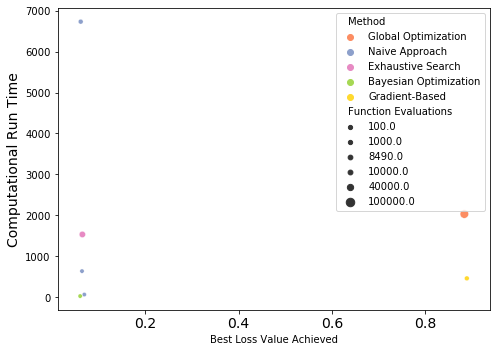

In [117]:
pal = sns.color_palette("Set2")[1:6]
fig, axs = plt.subplots(1,1,figsize=(7, 5))

ax = axs
sns.scatterplot(data=visualization_data, y='Computational Time', x='Best Loss', size='Function Evaluations', hue='Method', palette=pal, ax=ax
)
ax.set_ylabel('Computational Run Time', fontsize=14)
ax.set_xlabel('Best Loss Value Achieved')
ax.tick_params(axis='x', labelsize=14)
fig.tight_layout()


In [184]:
visualization_data = visualization_data.reset_index(drop=True)
visualization_data['Method Name'] = [visualization_data.Method[i].split(' 1')[0] for i in range(len(visualization_data))]

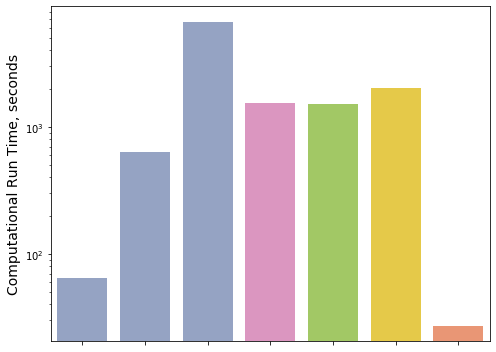

In [185]:
pal = sns.color_palette("Set2")[2:6]
pal.append(sns.color_palette("Set2")[1])
fig, axs = plt.subplots(1,1,figsize=(7, 5))
ax = axs
plot = sns.barplot(data=visualization_data, y='Computational Time', x='Method', hue='Method Name', palette=pal, ax=ax, dodge=False)
ax.set_ylabel('Computational Run Time, seconds', fontsize=14)
plot.set(xticklabels=[])
plot.legend_.remove()
ax.set_xlabel('')
ax.set_yscale('log')
# ax.tick_params(axis='x', labelsize=12)
# for item in plot.get_xticklabels():
#     item.set_rotation(45)
fig.tight_layout()
fig.savefig('benchmark_runtime.png', dpi=300, bbox_inches='tight', pad_inches=0.)


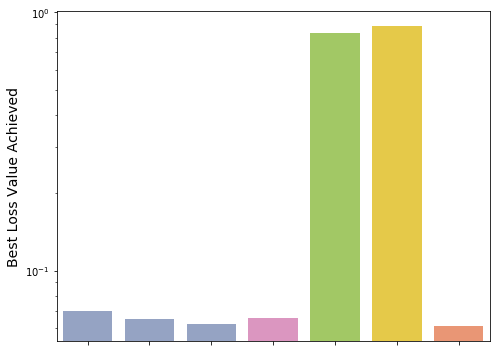

In [186]:
pal = sns.color_palette("Set2")[2:6]
pal.append(sns.color_palette("Set2")[1])
fig, axs = plt.subplots(1,1,figsize=(7, 5))
ax = axs
plot = sns.barplot(data=visualization_data, y='Best Loss', x='Method', hue='Method Name', palette=pal, ax=ax, dodge=False)
ax.set_ylabel('Best Loss Value Achieved', fontsize=14)
plot.set(xticklabels=[])
plot.legend_.remove()
ax.set_xlabel('')
ax.set_yscale('log')
# ax.tick_params(axis='x', labelsize=12)
# for item in plot.get_xticklabels():
#     item.set_rotation(45)
fig.tight_layout()
fig.savefig('benchmark_lossval.png', dpi=300, bbox_inches='tight', pad_inches=0.)


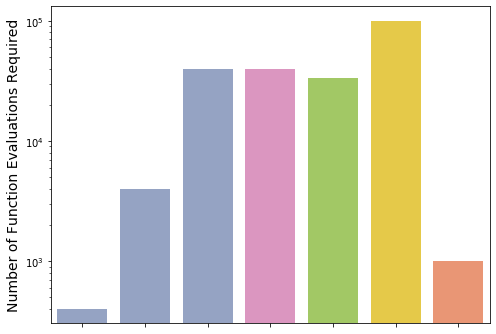

In [187]:
pal = sns.color_palette("Set2")[2:6]
pal.append(sns.color_palette("Set2")[1])
fig, axs = plt.subplots(1,1,figsize=(7, 5))
ax = axs
plot = sns.barplot(data=visualization_data, y='Function Evaluations', x='Method', hue='Method Name', palette=pal, ax=ax, dodge=False)
ax.set_ylabel('Number of Function Evaluations Required', fontsize=14)
plot.set(xticklabels=[])
plot.legend_.remove()
ax.set_xlabel('')
ax.set_yscale('log')
# ax.tick_params(axis='x', labelsize=12)
# for item in plot.get_xticklabels():
#     item.set_rotation(45)
fig.tight_layout()
fig.savefig('benchmark_nfev.png', dpi=300, bbox_inches='tight', pad_inches=0.)
